In [1]:
import pandas as pd
import json
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
from sklearn import linear_model
from datetime import datetime
from pylab import rcParams
from scipy.stats import skew
from mpl_toolkits.mplot3d import Axes3D
selecteddatapath = '/home/titli/Documents/Springboard1/Machinelearning/cleaned_data.csv'
numsamples=1000
rowsamples=200
pd.options.display.max_columns = 200

In [2]:
cleaned_data= pd.read_csv(selecteddatapath, header=0, index_col=0)
dataset1=cleaned_data[cleaned_data['Faker']==1]
dataset0=cleaned_data[cleaned_data['Faker']==0]

cleaned_data.describe()

,average_stars,review_count,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,cool,fans,funny,rev_length,rev_stars,rev_use,friend_count,friend_label,rev_count_label,buss_star,buss_review,alpha_length,length_lemmatize,NN,NNP,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,Faker
count,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.688800,8.280000,0.170000,0.0,0.170000,0.080000,0.0,0.035000,0.150000,0.080000,0.250000,0.385000,0.630000,0.750000,534.855000,3.645000,0.705000,13.735000,0.195000,0.855000,3.762500,347.730000,98.620000,47.720000,19.630000,0.020000,3.935000,0.090000,0.180000,5.520000,2.420000,8.150000,0.160000,0.050000,0.53000,5.015000,7.220000,1.735000,1.945000,2.680000,2.035000,0.385000,0.360000,0.525000,0.500000
std,1.253741,16.662225,0.913935,0.0,0.913935,0.452353,0.0,0.306995,0.787784,0.752617,0.944436,1.558499,5.567593,4.385621,536.602446,1.662164,1.424119,58.262832,0.685071,0.660421,0.896584,769.966779,101.510975,46.028302,18.610612,0.172478,4.260462,0.303911,0.537629,8.171503,2.887088,9.122147,0.442015,0.218492,1.10235,5.965123,8.557321,2.462742,2.429297,3.990894,3.295158,0.965107,0.820834,1.036701,0.501255
min,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,216.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.500000,26.250000,39.000000,20.000000,8.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.00000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.915000,3.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,389.000000,5.000000,0.000000,0.000000,0.000000,1.000000,4.000000,90.500000,72.500000,34.500000,14.000000,0.000000,3.000000,0.000000,0.000000,3.000000,1.000000,6.000000,0.000000,0.000000,0.00000,4.000000,5.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.500000
75%,5.000000,7.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,620.250000,5.000000,1.000000,0.000000,0.000000,1.000000,4.500000,232.250000,113.000000,55.250000,22.250000,0.000000,5.000000,0.000000,0.000000,6.000000,3.000000,10.000000,0.000000,0.000000,1.00000,6.000000,9.000000,2.000000,3.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000
max,5.000000,154.000000,8.000000,0.0,8.000000,4.000000,0.0,4.000000,9.000000,10.000000,7.000000,15.000000,77.000000,56.000000,4950.000000,5.000000,10.000000,428.000000,3.000000,4.000000,5.000000,5950.000000,926.000000,407.000000,150.000000,2.000000,32.000000,2.000000,4.000000,77.000000,15.000000,93.000000,3.000000,1.000000,8.00000,52.000000,47.000000,15.000000,13.000000,43.000000,38.000000,9.000000,4.000000,8.000000,1.000000


### Find trend difference between Real and Fake reviewers

In [6]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])


### Charecterestics of review text

In [4]:
def bar_plot_compare_fake_real(x,y,bins,xlabel,figname):
    """ This function creates bar chart to compare the cncellation rates for a fiven weather factor's two broad
    regime, both at origin and destination airports
    
    Parameters
    ----------
    x (dtype: pd.DataFrame): The data frame of fake
    y (dtype: pd.DataFrame): The data frame of real
    xlab (dtype: str): The label on x-axis
    ylab (dtype: str): The label on y-axis
    title (dtype: str): The title of the plot
    ylim (dtype: list): The list of numbers to limit y-axis. Example: [0, 12.5]
    """
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_style("white")
    sns.despine()
    ax1 = sns.distplot(x, bins=bins, 
                   kde=True, hist_kws=dict(edgecolor='k', lw=0.5, alpha=0.5), color = tableau20[2], kde_kws={'linewidth': 4})
    ax2 = sns.distplot(y, bins=bins, 
                   color='Blue', kde=True, hist_kws=dict(edgecolor='k', lw=0.5, alpha=0.3), kde_kws={'linewidth': 4})
    ax1.set_xlabel(xlabel, fontsize=20)
    ax1.set_ylabel('Density', fontsize=20)
    ax1.tick_params(direction='out', length=6, width=2, colors='k')
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    #vals = ax.get_yticks()
    #plt.yticklabels(['{:3.1f}%'.format(y) for y in vals])
    #plt.setp( ax.xaxis.get_majorticklabels(), rotation=0)
    # Hide the right and top spines
    sns.despine(top=True, right=True, left=False, bottom=False) 
    plt.legend(loc='upper right', fontsize=20,labels=['Fake','Real'])
    plt.savefig(figname, bbox_inches='tight')
    plt.show()


/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


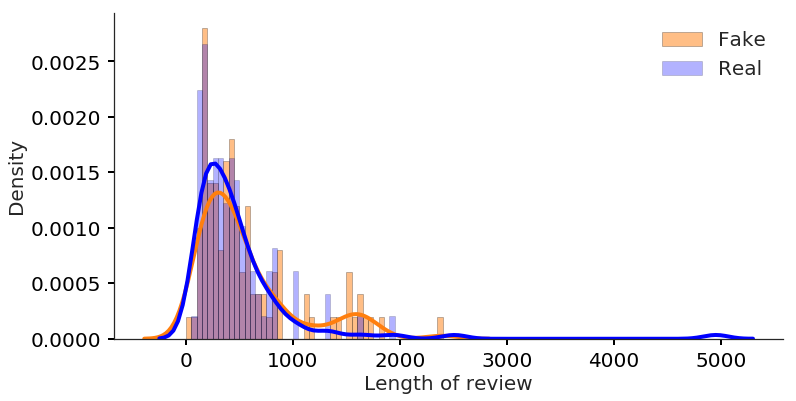

In [57]:
x = dataset1['rev_length']
y = dataset0['rev_length']
extent = range(0, 2500, 50)
bar_plot_compare_fake_real(x,y, extent,'Length of review', '3.png')

/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


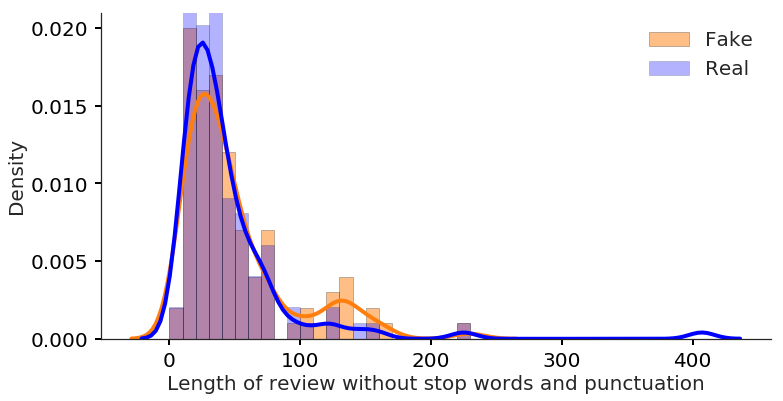

<Figure size 864x432 with 0 Axes>

In [58]:
x = dataset1['length_lemmatize']
y = dataset0['length_lemmatize']
extent = range(0, 400, 10)
bar_plot_compare_fake_real(x,y, extent, 'Length of review without stop words and punctuation','4.png')
plt.savefig('4.png', bbox_inches='tight')

/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


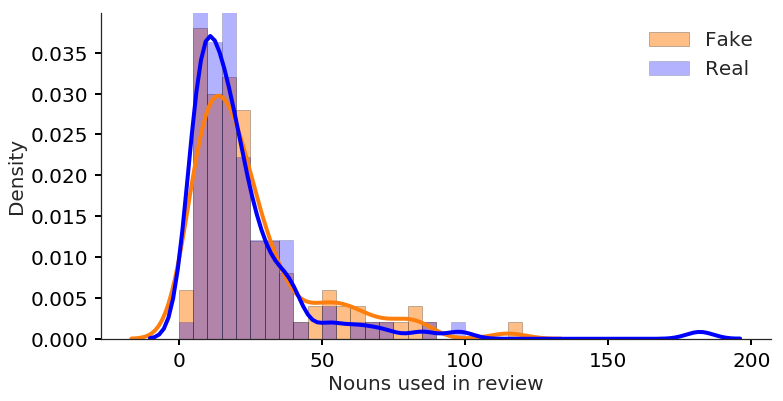

<Figure size 864x432 with 0 Axes>

In [59]:
Noun1=dataset1['NN'] + dataset1['NNP']+ dataset1['NNS']
Noun0=dataset0['NN'] + dataset0['NNP']+ dataset0['NNS']
extent = range(0, 180 , 5)
bar_plot_compare_fake_real(Noun1,Noun0, extent, 'Nouns used in review', '5.png')
plt.savefig('5.png', bbox_inches='tight')

/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


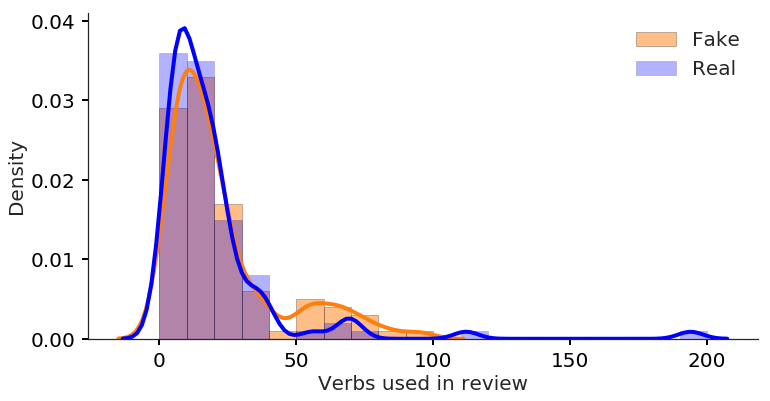

<Figure size 864x432 with 0 Axes>

In [61]:
verb1=dataset1['VB'] + dataset1['VBD']+ dataset1['VBG']+ dataset1['VBN']+ dataset1['VBP']+ dataset1['VBZ']
verb0=dataset0['VB'] + dataset0['VBD']+ dataset0['VBG']+ dataset0['VBN']+ dataset0['VBP']+ dataset0['VBZ']
extent = range(0, 200 + 10, 10)
bar_plot_compare_fake_real(verb1,verb0, extent, 'Verbs used in review','6.png')
plt.savefig('6.png', bbox_inches='tight')

### Social profile

/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


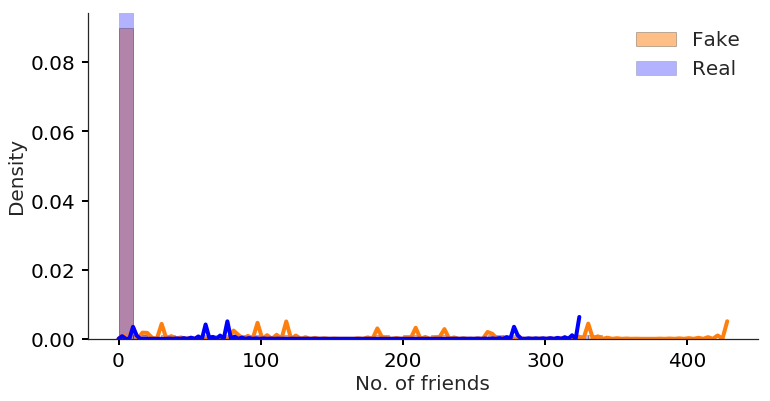

<Figure size 864x432 with 0 Axes>

In [62]:
x1=(dataset1['friend_count'])
x2=(dataset0['friend_count'])
extent = range(0, 400 + 10, 10)
bar_plot_compare_fake_real(x1,x2, extent, 'No. of friends','7.png')
plt.savefig('7.png', bbox_inches='tight')

/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


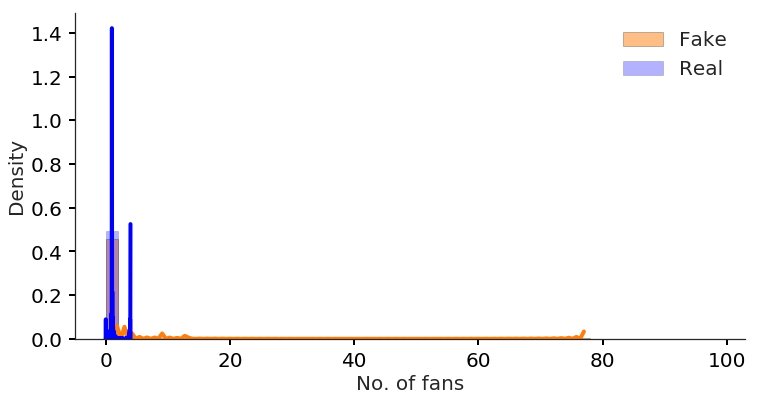

<Figure size 864x432 with 0 Axes>

In [63]:
y1=dataset1.fans #[dataset1['fans']>0]
y2=dataset0.fans #[dataset0['fans']>0]
extent = range(0, 100 , 2)
bar_plot_compare_fake_real(y1,y2,extent, 'No. of fans','8.png')
plt.savefig('8.png', bbox_inches='tight')


### Relation between no. of reviews and usefulness

label=0 : Only one review.
<br>
label=1 : More than 1 and upto 20 reviews.
<br>
label=2 : More than 20 and upto 50 reviews.
<br>
label=3 : More than 50 and upto 100 reviews.
<br>
label=4 : More than 100 reviews.

Fake reviewer profiles about >> 30 one reviews i.e Fake reviewers write mostly one reviews compared to real real reviews who write more than one reviews.


/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/titli/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


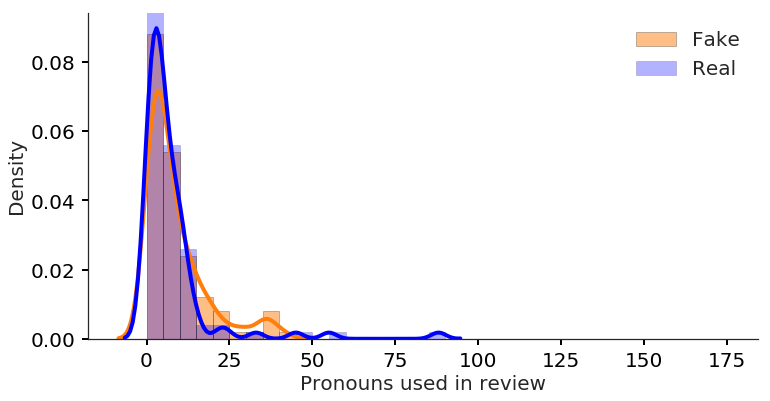

<Figure size 864x432 with 0 Axes>

In [7]:
pronoun1=dataset1['PRP$'] + dataset1['PRP']
pronoun0=dataset0['PRP$'] + dataset0['PRP']
extent = range(0, 180 , 5)
bar_plot_compare_fake_real(pronoun1,pronoun0, extent, 'Pronouns used in review', '16.png')
plt.savefig('16.png', bbox_inches='tight')

In [16]:
def crosstab_plot_review (x1,x2, y1, y2, title1, title2, xlabel, ylabel):
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_style("white")
    sns.despine()
    f,(ax1,ax2) = plt.subplots(1, 2, sharey='row', figsize=(12,6))
    set1 = pd.crosstab(index=x1, columns=y1)
    set1.plot(kind="bar", stacked=True, ax=ax1)
    ax1.set_title(title1,  size=20)
    ax1.set_xlabel(xlabel, size=20)
    ax1.set_ylabel(ylabel, size=20)
    ax1.tick_params(direction='out', length=6, width=2, colors='k')
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:3.0f}'.format(y) for y in vals])
    plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0)
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    set2= pd.crosstab(index=x2, columns=y2)
    set2.plot(kind="bar", stacked=True, ax=ax2)
    ax2.set_title(title2, size=20)
    ax2.set_xlabel(xlabel, size=20)
    ax2.set_ylabel(ylabel,size=20)
    ax2.tick_params(direction='out', length=6, width=2, colors='k')
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
    vals = ax1.get_yticks()
    ax2.set_yticklabels(['{:3.0f}'.format(y) for y in vals])

    plt.setp( ax2.xaxis.get_majorticklabels(), rotation=0)
    # Hide the right and top spines
    sns.despine(top=True, right=True, left=False, bottom=False)

<Figure size 864x432 with 0 Axes>

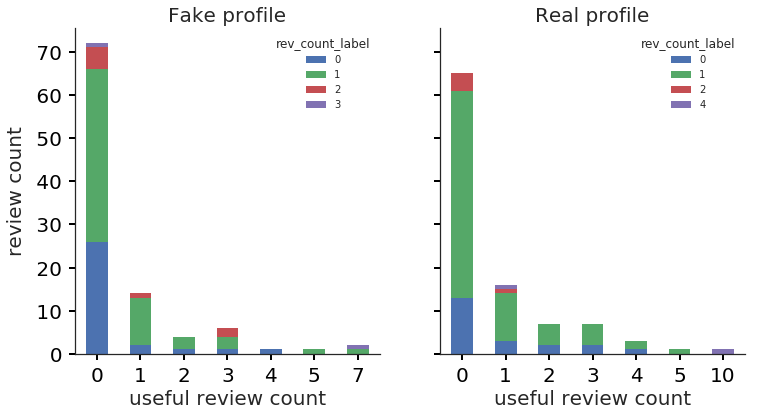

In [17]:
x1=dataset1['rev_use']
y1=dataset1['rev_count_label']
x2=dataset0['rev_use']
y2=dataset0['rev_count_label']
crosstab_plot_review(x1,x2, y1, y2, 'Fake profile', 'Real profile', 'useful review count', 'review count')
plt.savefig('8.png', bbox_inches='tight')

### Rating of business

<Figure size 864x432 with 0 Axes>

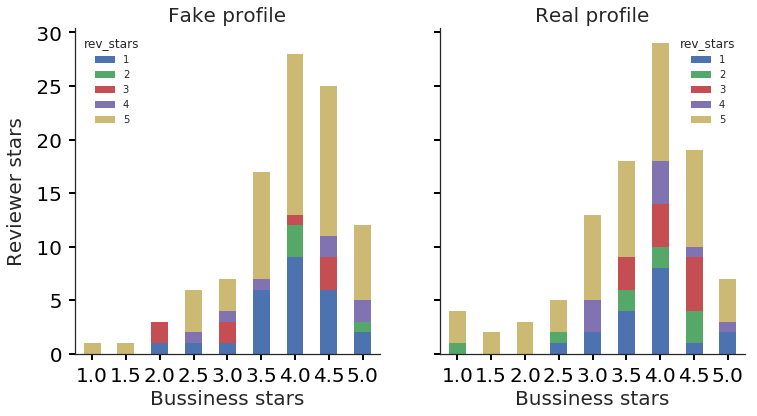

In [18]:
x1=dataset1['buss_star']
y1=dataset1['rev_stars']
x2=dataset0['buss_star']
y2=dataset0['rev_stars']
crosstab_plot_review(x1,x2, y1, y2, 'Fake profile', 'Real profile', 'Bussiness stars', 'Reviewer stars')
plt.savefig('9.png', bbox_inches='tight')

### Distribution of actual Bussiness stars and stas rating given by reviewer

In case of a real profile 3.5, 4.0, 4.5 and 5 star bussiness received ratings more postive ratings than 1 and 2 stars. However in fake profile 3.5, 4.0 and 4.5 businesses are rated 1 stars by more than 7 fake reviewers.


### Line fitting

/home/titli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


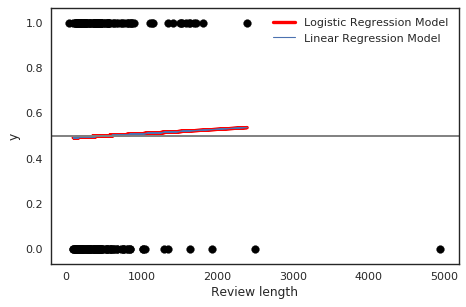

<Figure size 864x432 with 0 Axes>

In [19]:
#cleaned_data[['average_stars', 'Faker']].plot(kind='scatter', x='average_stars', y='Faker')
feature_colums= 'rev_length'.split()
from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
X = (cleaned_data[feature_colums])
y= cleaned_data['Faker']
X_train=X.values[:160,:]
X_test=X.values[160:,]
y_train =y.values[:160,]
# Fit the classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
# and plot the result
plt.clf()
plt.scatter(X, y, color='black', zorder=20)
def model(x):
    return 1 / (1 + np.exp(-x))

loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('Review length')
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="upper right", fontsize='small')
plt.tight_layout()

plt.show()
plt.savefig('10.png', bbox_inches='tight')

In [ ]:
#cleaned_data[['average_stars', 'Faker']].plot(kind='scatter', x='average_stars', y='Faker')
feature_colums= 'rev_length'.split()
from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
X = (cleaned_data[feature_colums])
X=X.drop(X.index[130])
X=X.drop(X.index[107])
#X= X.drop(X.index=p)
y= cleaned_data['Faker']
y=y.drop(y.index[130])
y=y.drop(y.index[107])
X_train=X.values[:160,:]
X_test=X.values[160:,]
y_train =y.values[:160,]
# Fit the classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
# and plot the result
plt.clf()
plt.scatter(X, y, color='black', zorder=20)
def model(x):
    return 1 / (1 + np.exp(-x))

loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('Review length')
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="center right", fontsize='medium')
plt.tight_layout()
plt.title('removing outliers')
plt.show()


### Distribution of length of review for faker vs real profile
From the plot the faker profile has a $\mu = 500$ and the real profile has $\mu = 520$ higher than real profile. In real profile some outliers are present. The real profile dataset is left skewed mean (500) $<$ mode (592). The fake profile dataset is right skewed mean (520) $>$ mode (468). 
<br>
Faker $(min, max, \sigma, \mu) = 47, 2398.0, 476.1, 566.87 $
<br>
Real $(min, max, \sigma, \mu) =  99, 4950.0, 591.7, 502.9 $
<br>
The linear / logistic regression do not fit the data well because in both algorithms the error is minimised. Since the distribution is not uniform hence the fitting is not good. In the next plot removing the outlier that are $>$ 2500 the regression is trying to fit the dataset little better. If the dataset is equally distributed a line that is passing through (1000,1) and (900,0) would have fit the data perfectly. 